<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/ML_Bias/S13_14_Bias_in_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asessing Bias in Machine Learning Models**

This notebook discusses issues of bias in predictive Machine Learning algorithms. As an example, we will be relying on the contentious case of COMPAS, which is a proprietary software designed by Northpointe Inc. (now part of [Equivant](https://www.equivant.com/)) and used throughout the United States in bail and sentencing decisions. For some background about COMPAS and the dispute initiated by journalists from ProPublica, check out these articles:
- https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing
- https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

We have three goals with this notebook and the associated analysis in Excel:
1. To construct a Machine Learning model that predicts recidivism using the same dataset used in the ProPublica analysis;
2. To evaluate our algorithm's performance, and most importantly, see if it suffers from similar biases as COMPAS;
3. To discuss broader issues of **bias and fairness** in predictive ML models: how they can arise, how they can be detected, and how they can be fixed (or avoided).

______
<a id="2"></a>
# **Basic Setup**
Let's load all the packages we need in Python.

_**Please run this entire section.** No need to worry about understanding any of this code._

In [1]:
#@title Import revelant modules and define a few useful functions
import os
import sys
assert sys.version_info >= (3, 5)   # Python ≥3.5 is required
import urllib.request # for file downloading

import numpy as np   # numpy for numerical linear algebra
import pandas as pd  # pandas for managing dataframes

#import tensorflow as tf
#from tensorflow.keras import layers

import sklearn
assert sklearn.__version__ >= "0.20"  # Scikit-Learn version ≥0.20 required
import sklearn.metrics as metrics

# adjust reporting in pandas: max 15 rows and two-digit precision
#pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

# import matplotlib and pyplot: critical packages for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline  
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install the latest version of seaborn for nicer graphics
!pip install seaborn==0.11.0  &> /dev/null
import seaborn as sns

# install facets overview
!pip install facets-overview &> /dev/null
# import facets overview + some other relevant packages
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

# install graphviz for visualizing decision trees
!pip install graphviz  &> /dev/null
import graphviz

# install pdpbox for partial dependency visualization
!pip install pdpbox &> /dev/null
from pdpbox import info_plots, pdp

# import useful utilities from Google colab
from google.colab import files

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

# Create a function to save figures to a desired local folder
FIGURE_FOLDER = "Figures"
FIGURE_PATH = os.path.join(".",FIGURE_FOLDER)
os.makedirs(FIGURE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# A function to append dummies for specified variables 
# returns the new dataframe and a dictionary with the categories for each categorical variable turned into a dummy
def append_dummies(data, columns):
  categories = {}  # the dictionary with categories
  data_with_dummies = data.copy() # the changed dataframe
  for col in columns:
    if col not in data.columns:
      print("WARNING. Column '{}' not among the columns in the dataframe. Skipping it.")
    elif (data[col].dtype!=int and data[col].dtype!=float):
      dummy_df = pd.get_dummies(data[col], prefix=col)
      categories[col] = list(dummy_df.columns)  # keep all the categories
      data_with_dummies = pd.merge( left=data_with_dummies, \
                                    right=dummy_df, \
                                   left_index=True, right_index=True,\
                                   how="inner", suffixes=("", "") )
  return data_with_dummies, categories

print("Done with everything!")

Done with everything!


_________
<a id="3"></a>
# **Load the Data and Take a Look**
We download our data from the ProPublica Github site, and then follow a similar cleaning and filtering process as in their analysis.



In [2]:
#@title Download the data, process it following ProPublica's rules, and save it

#@markdown 1) Download data from ProPublica GitHub account and save it as a CSV file
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"  # full URL to the dataset
local_csv = "compas_data.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally

# Read the data into a `pandas` DataFrame
raw_data = pd.read_csv(local_csv, index_col="id")

#@markdown 2) Filter the data using the same criteria as ProPublica
data = raw_data[ ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", \
              "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"] ]

data = data.loc[ (data["days_b_screening_arrest"] <= 30) & (data["days_b_screening_arrest"] >= -30) & (data["is_recid"] != -1) & \
       (data["c_charge_degree"] != "O") & (data["score_text"] != "N/A") ]

#@markdown - In addition, we remove a few more columns to avoid confusion:
#@markdown  - **c_jail_in**, **c_jail_out**, **days_b_screening_arrest** : these are not useful in the prediction
#@markdown  - **is_recid** is a flag used by ProPublica, not needed for prediction
#@markdown  - **age** and **age_cat** are redundant; we keep **age**
data.drop(columns=["c_jail_in","c_jail_out", 'days_b_screening_arrest','age_cat', "is_recid"], inplace=True)
data.drop(columns=["score_text"], inplace=True)  # we also drop the text score for COMPAS
#data.drop(columns=["score_text","decile_score"], inplace=True)  # drop all the COMPAS scores

#@markdown - To focus our classroom discussion, we also remove all records where **race** is different than African-American or Caucasian
data = data.loc[ (data["race"]=='African-American') | (data["race"]=='Caucasian') ]
# #@markdown  - since the data has very few **Asian** and **Native American** records, we re-label these as **Other**
# #data.loc[ (data["race"]=='Asian') | (data["race"]=='Native American'), "race" ] = "Other"

print("Done with all data processing tasks!")

#@markdown 3) If desired, save the processed data as an Excel file and download it to your local machine
download_to_Excel = False #@param {type:"boolean"}

#markdown Write the processed data to an Excel file and download that file to your local machine
if download_to_Excel :
    data.to_excel('compas_data_processed.xlsx', sheet_name='Filtered_data', na_rep='', verbose=True, freeze_panes=None)
    files.download('compas_data_processed.xlsx')

Done with all data processing tasks!


In [3]:
#@title Take a quick look at the dataframe
data.head(10)

,age,c_charge_degree,race,sex,priors_count,decile_score,two_year_recid
id,,,,,,,
3,34,F,African-American,Male,0,3,1
4,24,F,African-American,Male,4,4,1
8,41,F,Caucasian,Male,14,6,1
10,39,M,Caucasian,Female,0,1,0
14,27,F,Caucasian,Male,0,4,0
15,23,M,African-American,Male,3,6,1
16,37,M,Caucasian,Female,0,1,0
18,41,F,African-American,Male,0,4,0
19,47,F,Caucasian,Female,1,1,1


__________
<a id="1"></a>
# **The Prediction Problem and the Data Dictionary**
The specific prediction problem we are interested in is a **binary classification** task: we would like to predict whether a defendant is going to reoffend (i.e., commit another crime) within the next two years, based on information including criminal history and other personal features.

_For a detailed data dictionary, click to expand the hidden cells._

**How was the data collected and processed?**<br>
We are using the same dataset published by ProPublica of its [Github site](https://github.com/propublica/compas-analysis). The data is based on information on defendants from Broward County (Florida), and we used a similar process to ProPublica for cleaning and filtering it. The **data dictionary** for our fields is as follows:  
  *   `age`: The defendant's age (numeric)
  *   `c_charge_degree`: The type of crime for which the arrest was made (Categorical field with two potential values: **M** for **misdemeanor**, which is a less serious crime or **F** for **felony**, which is a more serious crime)
  *   `race`: The defendant's race (categorical field; to simplify our task, we only kept records that were either **African American** or **Caucasian**)
  *   `sex`: The defendent's gender (categorical field with value **Male** or **Female**)
  *   `priors_count`: Total number of prior convictions for the defendant (numeric)
  *   `decile_score`: This is the COMPAS risk score (1-10) received by the defendant when screened with the algorithm. (_We will <font color=red>not</font> use this feature when constructing our own risk-scoring tool, but we will use it to analyze the bias and accuracy of the COMPAS algorithm._) 
  *    `two_year_recid`: Indicator for whether the defendant reoffended within two years from the date of the scoring (1 for YES, 0 for NO).

**What are we trying to predict / what is the precise target?**<br>
The specific problem we are interested in is a **binary classification** task: we would like to determine the likelihood that a defendant is going to reoffend (i.e., commit another crime) within the next two years. So **the target in our prediction problem is `two_year_recid`.**

_________________
<a id="5"></a>
# **1. Exploratory Data Analysis**
Feel free to explore the data using one of the tools we introduced before.

*This is obviously an important section. We suggest expanding the hidden cells and then choosing which sub-section to expand further.*

## Full Analysis with **Google Facets**
*Expand this sub-section as needed.*

In [4]:
#@title Visualize the Data in **Facets Overview**

# generate the visualization
gfsg = FeatureStatisticsGenerator()

proto = gfsg.ProtoFromDataFrames([{'name': 'original_data', 'table': data}])
# uncomment next two lines if you want to visualize training & test sets
#proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train_set},
#                                  {'name': 'test', 'table': test_set}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [5]:
#@title Correlation Analysis in **Facets Dive**

SAMPLE_SIZE = 5000 #@param
  
data_dive = data.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=data_dive)
display(HTML(html))

<a id="EDA-NutsBolts"></a>
## Nuts & Bolts

*As you start conducting <font color=red>**TASK #1**</font>, you may want to expand certain sections here to compare outputs.*

In [6]:
#@markdown Define various functions to help with visualizations

# #@markdown - a function for simple visualizations of one or more features with histograms/boxplots/countplots
def visualize_features(all_data, features, figsize=(6,6), num_plot='histogram', \
                       num_bins='auto', num_cols=3):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else num_cols)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    title = ''

    for i in range(num_figs):

      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      ax1.grid(alpha=.5, linewidth=1)

      if( (all_data[features[i]].dtype == 'float') or (all_data[features[i]].dtype == 'int') ):
        # numeric feature 
        
        # plot the feature according to the option
        if( num_plot == 'histogram'):
          #title = "Histogram of {}".format(features[i])
          sns.histplot(data = all_data[features[i]], bins=num_bins, color="skyblue", ax=ax1)

        elif( num_plot == 'boxplot' ):
          #title = "Boxplot of {}".format(features[i])
          sns.boxplot(data = all_data[features[i]], color="skyblue", ax=ax1)
        plt.tight_layout()

      else:
        # categorical feature
        sns.countplot(data = all_data, x=features[i], palette="Blues", ax=ax1)
        plt.tight_layout()

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

#
#
# #@markdown - A function to visualize **average dependency** of one numeric feature as a function of two other features
def visualize_average_dependency(all_data_with_dummies, all_categories, \
                                 feature_y, feature_x1, feature_x2=None,\
                                 num_bins=10, uniform_bins=False, \
                                 show_outliers=False, figsize=(10,9)):
   
    # append to all categories a string for numeric categories
    all_feats = [feature_y, feature_x1]
    if feature_x2 != None:
      all_feats += [feature_x2]

    categ_for_infoplot = all_categories.copy()
    for feat_ in all_feats:
      if feat_ not in all_categories.keys():
        # just the names for numeric features
        categ_for_infoplot[feat_] = feat_

    if uniform_bins:
      grid_type='equal'
    else:
      grid_type='percentile'

    # do all the infoplots
    if feature_x2==None:
      # visualizing just two features, so a simple target_plot will do
      title = "Relation between target '{}' and feature '{}'".format(feature_y,feature_x1)
      subtitle = "The count/height of bars shows the number of samples where {} takes that value".format(feature_x1) +\
        "\n and the line plot shows the average value of the target."

      fig, axes, summary_df = \
      info_plots.target_plot(df=all_data_with_dummies, \
                            feature=categ_for_infoplot[feature_x1], \
                            feature_name=feature_x1, \
                            target=categ_for_infoplot[feature_y],\
                            num_grid_points=num_bins, grid_type=grid_type, \
                            percentile_range=None, \
                            grid_range=None, cust_grid_points=None, \
                            show_percentile=False, \
                            show_outliers=show_outliers, endpoint=True, \
                            figsize=figsize, ncols=2, \
                            plot_params={"title" : title, "subtitle": subtitle})
    else:
      # plotting y as color-coded, as a function of x1 and x2
      title = "Relation between target '{}' and features '{}' and '{}'".format(feature_y,feature_x1,feature_x2)
      subtitle = "The circle color shows the average value of the target" +\
        "\n and the circle size shows the number of samples."

      fig, axes, summary_df = \
      info_plots.target_plot_interact(df=data_with_dummies, \
                                      features=[categ_for_infoplot[feature_x1],categ_for_infoplot[feature_x2]], \
                                      feature_names=[feature_x1,feature_x2], \
                                      target=categ_for_infoplot[feature_y], \
                                      num_grid_points=[num_bins,num_bins], \
                                      grid_types=[grid_type,grid_type], \
                                      percentile_ranges=None, \
                                      grid_ranges=None, cust_grid_points=None, \
                                      show_percentile=False, \
                                      show_outliers=show_outliers, endpoint=True, \
                                      figsize=figsize, ncols=2, annotate=True, \
                                      plot_params={"title" : title, \
                                                    "subtitle" : subtitle})    
#
#
#
# #@markdown - A complex function to visualize relationships among several features
def visualize_detailed_dependencies(all_data_with_dummies, all_categories, \
                                    target, feature, feature_color=None,\
                                    feature_breakdown=None, \
                                    plot_type='scatter', min_categ=5, orient=None,\
                                    figs_per_row=3, figsize=(10,9)):

    # check to see if there's a need to change the plot type
    if plot_type=='boxen':
        # check to make sure that either the target or one of the features is numerical with enough values
        if (target in data_categories.keys() \
            and feature in data_categories.keys() ) or \
            ( len(all_data_with_dummies[target].unique()) <= min_categ and \
             len(all_data_with_dummies[feature].unique()) <= min_categ ):
            # target and first feature are categorical or have very few values
            if feature_color in data_categories.keys() or \
            ( len(all_data_with_dummies[feature_color].unique()) <= min_categ):
              # second feature is also categorical or with very few values 
              # it means all features are categorical -> switch to countplot
              print('Target and all selected features are categorical or have very few values. Switching to a countplot.')
              plot_type = 'count'
            else:
              # third feature is numeric with enough values --> switch with first feature
              aux=feature
              feature=feature_color
              feature_color=aux

    if plot_type=='scatter':
        # simple scatter plot
        sns.relplot(data=data_with_dummies, x=feature, y=target, \
                    hue=feature_color, col=feature_breakdown, \
                    row=None, style=None, col_wrap=None, row_order=None, \
                    col_order=None, palette=None, hue_order=None, hue_norm=None, \
                    sizes=None, size_order=None, size_norm=None, markers=None, \
                    dashes=None, style_order=None, legend='auto', \
                    kind='scatter', height=figsize[1], \
                    aspect=figsize[0]/figsize[1], facet_kws=None, units=None)

    if plot_type=='count':
        sns.catplot(data=data_with_dummies, x=target, y=None,\
                    hue=feature, col=feature_breakdown, \
                    kind=plot_type, row=None, col_wrap=None, \
                    row_order=None, col_order=None, \
                    ci=95, n_boot=1000, units=None, seed=None, order=None, \
                    hue_order=None, height=figsize[1], aspect=figsize[0]/figsize[1], \
                    orient=orient, color=None, palette=None, legend=True, \
                    legend_out=True, sharex=True, sharey=True, \
                    margin_titles=False, facet_kws=None)

    if plot_type=='boxen':
        # check if the number of categories for the target is smaller than for the feature
        if( len(all_data_with_dummies[target].unique()) < \
           len(all_data_with_dummies[feature].unique()) ):
          orient='h'
        sns.catplot(data=data_with_dummies, x=feature, y=target, \
                    hue=feature_color, col=feature_breakdown, \
                    kind=plot_type, row=None, col_wrap=None, \
                    row_order=None, col_order=None, \
                    ci=95, n_boot=1000, units=None, seed=None, order=None, \
                    hue_order=None, height=figsize[1], aspect=figsize[0]/figsize[1], \
                    orient=orient, color=None, palette=None, legend=True, \
                    legend_out=True, sharex=True, sharey=True, \
                    margin_titles=False, facet_kws=None)      

### Examine the Data Types
A good start is to check more carefully the kind of values that each attribute takes in the dataset.<br>
<font color=green>**EXCEL:** You can add a [**Filter**](https://support.microsoft.com/en-us/office/filter-data-in-a-range-or-table-01832226-31b5-4568-8806-38c37dcc180e#:~:text=Select%20any%20cell%20within%20the,filter%20criteria%20and%20select%20OK.) from the **Data** menu, and glance at the values for each field.</font>

In [7]:
#@markdown Examine the Data Types

# take a look at the type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5278 entries, 3 to 11000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              5278 non-null   int64 
 1   c_charge_degree  5278 non-null   object
 2   race             5278 non-null   object
 3   sex              5278 non-null   object
 4   priors_count     5278 non-null   int64 
 5   decile_score     5278 non-null   int64 
 6   two_year_recid   5278 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 329.9+ KB


### Summary Statistics and Counts
Summarize the data through various statistics and counts.<br>
<font color=green>**EXCEL:** Recall that you can do this using [**Descriptive Statistics**](https://www.excel-easy.com/examples/descriptive-statistics.html) from the **Data Analysis** TookPak, under the **Data** menu.</font>

In [8]:
#@markdown **Compute summary statistics for the numeric attributes**
data.describe()

,age,priors_count,decile_score,two_year_recid
count,"5,278.00","5,278.00","5,278.00","5,278.00"
mean,34.45,3.46,4.62,0.47
std,11.73,4.88,2.84,0.50
min,18.00,0.00,1.00,0.00
25%,25.00,0.00,2.00,0.00
50%,31.00,2.00,4.00,0.00
75%,42.00,5.00,7.00,1.00
max,80.00,38.00,10.00,1.00


In [9]:
#@markdown **Cross-tabulate one feature against one of the categorical features**

#@markdown - select a (numeric or categorical) feature and another categorical feature to cross-tabulate
feature = "two_year_recid" #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count','decile_score','two_year_recid']
feature_categorical = "sex" #@param ['c_charge_degree', 'race', 'sex']

#@markdown - select whether to show the values as fractions of the totals on rows or columns (selecting both will show as fraction of grand total)
fraction_of_row_total = True #@param { type:"boolean"}
fraction_of_column_total = True #@param { type:"boolean"}

normalize = False
if fraction_of_row_total:
  if fraction_of_column_total:
     normalize = 'all'
  else:
     normalize = 'index'
else:
  if fraction_of_column_total:
     normalize = 'columns'

pd.crosstab( index = data[feature], columns = data[feature_categorical] , \
            normalize=normalize, margins=True)

sex,Female,Male,All
two_year_recid,,,
0,0.12,0.40,0.53
1,0.07,0.40,0.47
All,0.20,0.80,1.00


### Histograms and Countplots
Build histograms and countplots to visualize the values of individual features.<br>
<font color=green>**EXCEL:** You can create histograms and boxplots from  **Insert > Insert Statistic Chart** ([click here](https://support.microsoft.com/en-us/office/create-a-histogram-85680173-064b-4024-b39d-80f17ff2f4e8) for details).<br> The most effective way to visualize categorical features in Excel is by creating a **Pivot Chart** from the **Insert** menu ([click here](https://support.microsoft.com/en-us/office/create-a-pivotchart-c1b1e057-6990-4c38-b52b-8255538e7b1c) for details).</font>

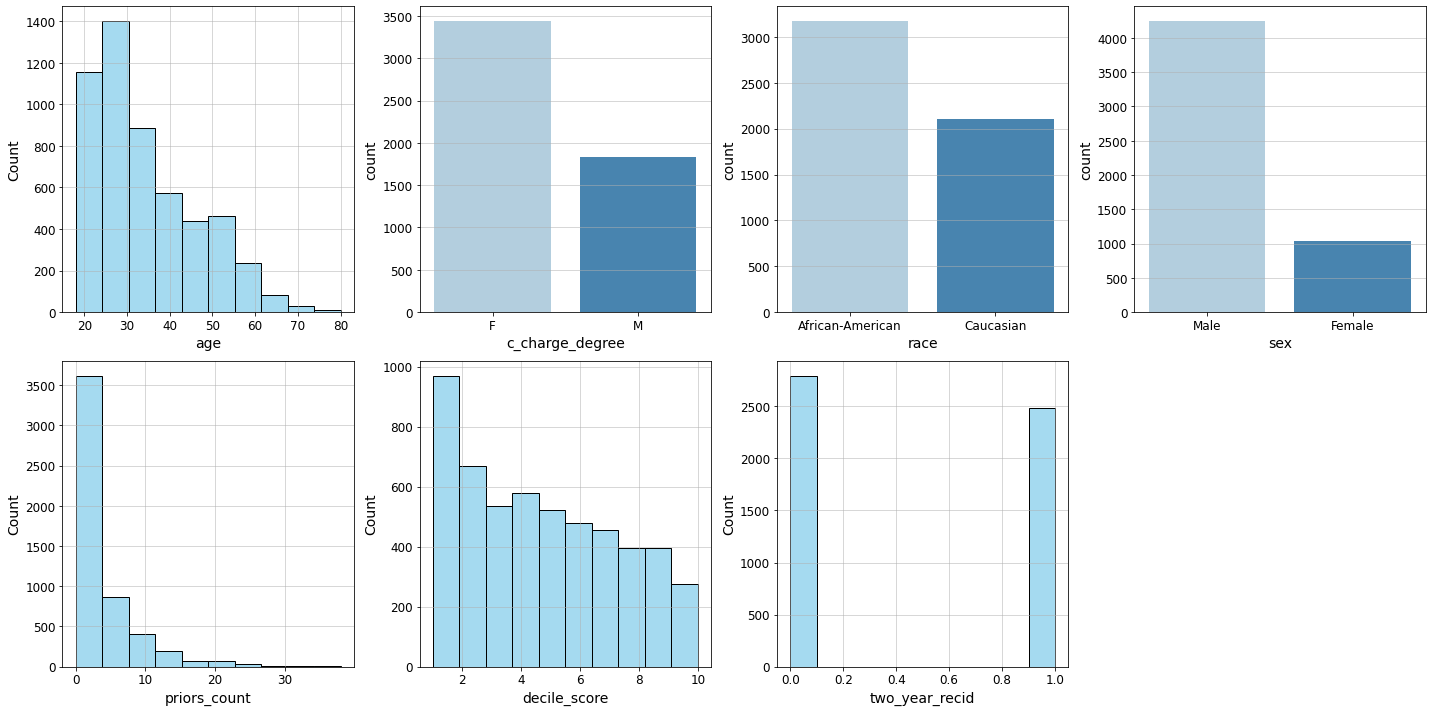

In [10]:
#@markdown **Build histograms for numeric features or countplots for categorical ones**

#@markdown Select which features(s) to visualize (picking **"All"** will plot dependencies for all features, but will take a bit more time):
feature = "All" #@param ['All', 'age', 'c_charge_degree', 'race',  'sex', 'priors_count', 'two_year_recid']

# complete list of features, just in case it's needed
# ['All', 'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'decile_score', 'is_recid', 'two_year_recid']

if(feature=="All"):
  # all features except ocean proximity (which is categorical)
  feature = list(data.columns)
else:
  feature = [feature]

#@markdown <br><br>**Feel free to customize some elements of the plot (leave as "Auto" if unsure)**

#@markdown Choose or type how many figures to display per row:
figures_per_row = "4" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figures_per_row=="Auto":
  figures_per_row=4
else:
  figures_per_row=np.int(figures_per_row)

#@markdown Choose or type how many bins to use for the histogram:
num_bins = "Auto" #@param ["Auto",5,10,20,50,100]{allow-input: true}
if num_bins=="Auto":
  num_bins=10
else:
  num_bins=np.int(num_bins)

#@markdown Choose or type the width and height for each figure in inches:
figure_width = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_width=="Auto":
  figure_width=5.0
else:
  figure_width=np.float(figure_width)

figure_height = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_height=="Auto":
  figure_height=5.0
else:
  figure_height=np.float(figure_height)

# plot the feature(s)
visualize_features(all_data=data, features=feature, \
                   figsize=(figure_width,figure_height), num_plot="histogram", \
                   num_bins=num_bins, num_cols=figures_per_row)

### Examine Dependencies
Examine the relationships and dependencies between the features by computing correlation coefficients and through various visualizations like scatter plots, boxen plots, or average dependency plots.

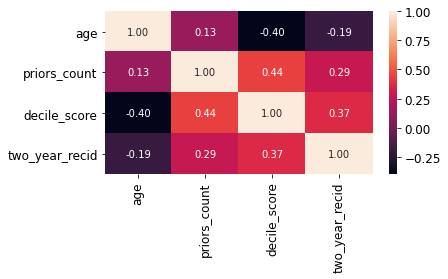

In [11]:
#@title **Display the entire correlation matrix**
# compute the matrix
corr_matrix = data.corr()

# plot the matrix as a heatmap
plt.figure(figsize = (6,3));
g = sns.heatmap(corr_matrix, annot=True, fmt=".2f")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.show()

Your selections:
Main feature/target :   two_year_recid
Feature_1 :             age
Feature_2 :             None
Breakdown feature :     None
Plot type:              average_dependency


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


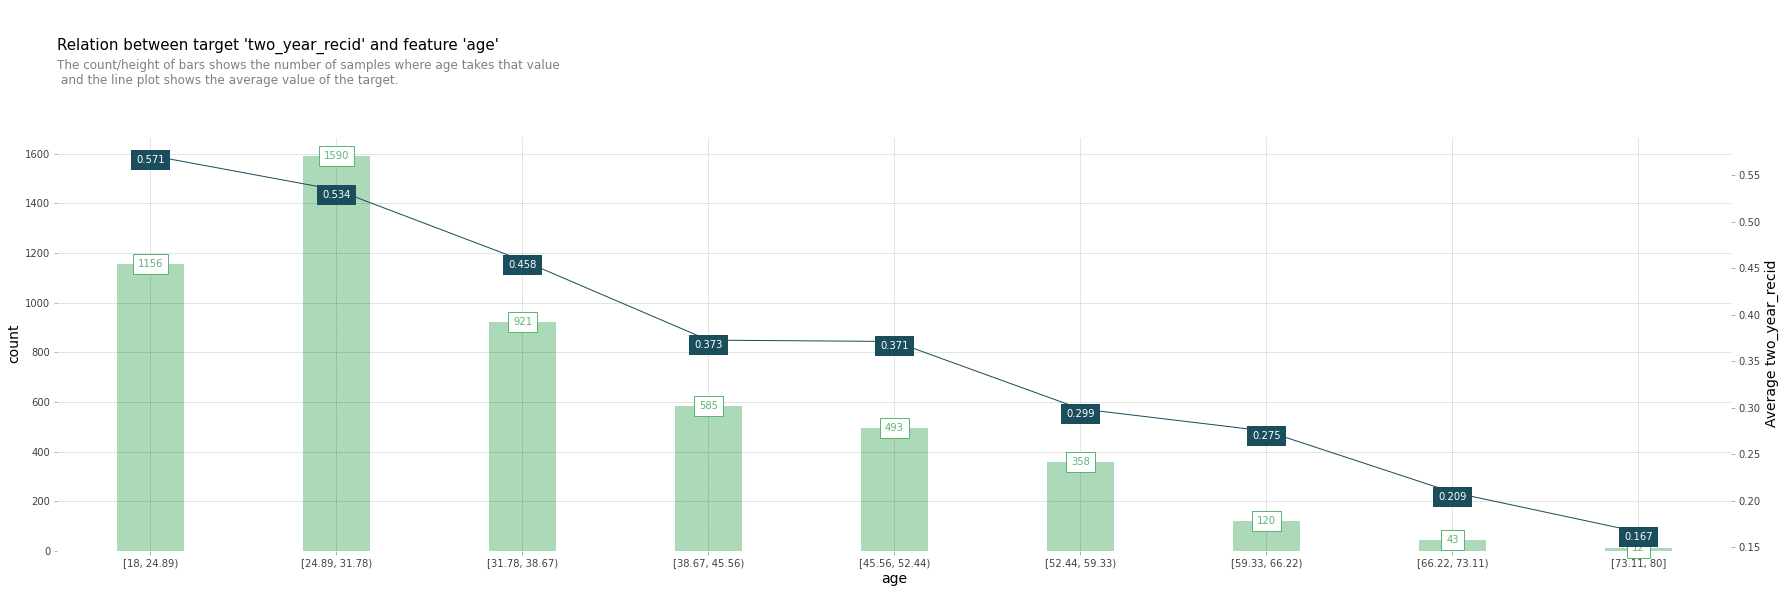

In [12]:
#@title **Visualize the relationships between features**

# append dummies and store categories for all data (useful for plotting routines)
data_with_dummies, data_categories = append_dummies(data, data.columns)

#@markdown Select the **main feature/target** for which you want to visualize dependencies:
main_feature = 'two_year_recid' #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'decile_score', 'two_year_recid']

#@markdown Select one feature, numeric or categorical:
feature_1 = 'age' #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'two_year_recid']

#@markdown (Optional) An additional numeric or categorical feature to visualize:
feature_2 = "None" #@param ['None', 'age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'two_year_recid']

#@markdown (Optional) A categorical feature to use for breaking down into several sub-plots:
breakdown_feature = "None" #@param ['None', 'c_charge_degree', 'race', 'sex']

#@markdown <br>**Select the type of plot to see**
#@markdown - **scatter** is the usual scatter plot you are familiar with
#@markdown - **average_dependency** displays the average value of the **`main_feature`**
#@markdown - **count** attempts to do a simple count plot
#@markdown - **boxen** attempts to do a boxen-plot (more detailed version of a boxplot)
plot_type = 'average_dependency' #@param ['average_dependency', 'scatter', 'count', 'boxen']

#@markdown <br>**You can further customize some aspects of the plot**

#@markdown General settings:
fig_width = '30' #@param ['Auto']{allow-input : true}
fig_height = '10' #@param ['Auto']{allow-input : true}

#@markdown For an average dependency plot:
#@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
#@markdown - **`equal_probability`** : whether to use bins with roughly equal probability (unchecking this will generate bins with equal width)
num_bins = '10' #@param ['Auto']{allow-input : true}
equal_probability = False #@param {type:"boolean"}

# print the selections
print("Your selections:")
print("Main feature/target :  ", main_feature)
print("Feature_1 :            ", feature_1)
print("Feature_2 :            ", feature_2)
print("Breakdown feature :    ", breakdown_feature)
print("Plot type:             ", plot_type)

# set up parameters properly
if feature_2=="None":
  feature_2 = None

if breakdown_feature=="None":
  breakdown_feature = None

if fig_width=='Auto':
  fig_width=7.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=7.0
else:
  fig_height=np.float(fig_height)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

if plot_type=='average_dependency':
    visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                  all_categories=data_categories, \
                                  feature_y=main_feature, feature_x1=feature_1,\
                                  feature_x2=feature_2,num_bins=num_bins,\
                                  uniform_bins=(not equal_probability),\
                                  show_outliers=True,\
                                  figsize=(fig_width,fig_height))

else:
    if plot_type=='categorical':
        # check to make sure that either the target or one of the features is numerical
        if main_feature in data_categories.keys() and feature in data_categories.keys():
            # target and first feature are categorical
            if feature_2 in data_categories.keys():
              # second feature is also categorical; since the third feature 
              # is also categorical by choice, all are categorical -> switch to countplot
              print('Target and all selected features are categorical. Switching to a countplot of target.')
              plot_type = 'count'
            else:
              # feature_2 is numeric, will switch with feature_1
              aux=feature_1
              feature_1=feature_2
              feature_2=aux

    visualize_detailed_dependencies(all_data_with_dummies=data_with_dummies, \
                          all_categories=data_categories, \
                          target=main_feature, \
                          feature=feature_1, \
                          feature_color=feature_2,\
                          feature_breakdown=breakdown_feature,\
                          plot_type=plot_type,\
                          figs_per_row=3, figsize=(fig_width,fig_height))

# uncomment next line to save
#save_fig("scatterplot_of_{}_and_{}".format(feature1,feature2))

__________
<a id="6"></a>
# **2. Split into a Training and a Test Set + Prepare the Data for ML Algorithms**

_For simplicity and to focus on the discrimination issues, we will use the entire dataset here as a training set. We already cleaned our data when we imported it, so here we are only transforming the categorical features. Expand for details._


In [13]:
#@title We will follow a very simple process here 

#@markdown 1. **Train/Test split**: We use the entire dataset as a training set
train_set = data
# uncomment if you prefer to do a simple 80-20 Random Split

#from sklearn.model_selection import train_test_split
#train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#@markdown 2. **Data cleaning** - already done when importing the data, following ProPublica's procedure

# make a copy of the training and testing here, before defining the categorical features
train_copy = train_set.copy()
#test_copy = test_set.copy()

#@markdown 3. **Handling Text and Categorical Features** - we transform any categorical features into "dummy variables"<br>
#@markdown We delay this step for now because we want to allow you to **select which features to use** in the model

#@markdown 4. **Feature scaling** - not needed here since we will be using ML methods that are not sensitive to scaling


_____
# **3. Train the Machine Learning Models**
We will train a **decision tree** and a **random forest**.

_Expand this section for a few options on which features to use during training._


## Our ML Models in a Nutshell 
_If you have never seen some of these models, you may want to uncomment this and read for a very quick description._

The two models that we are training can be quickly summarized as follows:
1. A **Classification Decision Tree** is very similar to a **Regression Decision Tree**, with a few small differences. Specifically:
* The basic logic of the tree is exactly the same as in a regression task: it relies on a sequence of **IF** statements to partition the space of predictors, and once a leaf node is reached, the final prediction for **<font color=green>the probability $\hat{p}_1$ that the target is equal to 1</font>** is given by **the average of the samples in the leaf node**. 
* Since for a classification task we are also interested in a **<font color=blue>final prediction  of 0 or 1 for the actual target $\hat{y}$</font>**, this can be obtained **by taking a majority vote based on the samples in the leaf**, i.e., by predicting 1 if most of the leaf samples have a target 1, and 0 otherwise. Note that this is exactly equivalent to **predicting 1 if and only if <font color=green>the predicted probability $\hat{p}_1$</font> exceeds the threshold 0.5**.
* Because the predicted target in a classification cannot take any possible values (the values are always between 0 and 1), instead of measuring the prediction error with **mean squared errors** or **mean absolute errors**, one of the following two approaches are used:
    - the **gini impurity index** in a node of the tree is given by $\sum_{k \in \{0,1\}} \hat{p}_k(1-\hat{p}_k)$, where $\hat{p}_k$ is the fraction of samples in the node that have a target value of $k$. To understand this error measure, note that it takes a value of 0 if either all the samples in the node take value 0 (i.e., $\hat{p}_0=1, \hat{p}_1=0$) or if all the samples take value 1 (i.e., $\hat{p}_0=0, \hat{p}_1=1$). Otherwise, it takes a positive value, and this is actually largest when exactly half the samples have target value 1 (i.e., $\hat{p}_1=\hat{p}_0 = 0.5$). Therefore, the gini index is really a measure of **node impurity**, with "low errors" when nodes are pure and "high errors" when they are split evenly.
    - the **entropy** is an alternative to the gini index, and is given by $- \sum_{k \in \{0,1\}} \hat{p}_k \log \hat{p}_k$. It is based on information theory (and the work of Claude Shannon), and it can also be shown to take a value 0 in pure nodes, and the largest value in nodes that have an even split of targets equal to 1 and 0.<br>
  Of the two error measures above, the gini impurity index is the more common one due to its simplicity. For more details on (Classification) Decision Trees, you can refer to [this Wikipedia page](https://en.wikipedia.org/wiki/Decision_tree_learning) or reference \#1 (see our **References** section).

2. A **Random Forest** is just an ensemble of many decision trees.

## **Train** or **Fit** the Models

_**Run the entire section.** As you conduct certain tasks, you may want to expand this and change the features used during training to see how this affects your model._

In [14]:
#@title Let's train our ML models.

#@markdown Select **which features** to include in the training by ticking the box:
#@markdown *(Start with all the features and return here later)*
age = True #@param {type:"boolean"}
#age_cat = True #@param {type:"boolean"}
c_charge_degree = True #@param {type:"boolean"}
race = True #@param {type:"boolean"}
sex = True #@param {type:"boolean"}
priors_count = True #@param {type:"boolean"}

# mapping between the variables and the names
selection = [age, c_charge_degree, race, sex, priors_count]

# all the names of features we could include 
all_features = ["age", "c_charge_degree", "race", "sex", "priors_count"]

target = "two_year_recid"
included_features = []  # list of names for all included features

X_train = None
#X_test = None

print("Variables included in the model and any transformations done to them:")
for i in range(len(all_features)):
  if( selection[i] ):
      # feature was elected
      col = all_features[i]
      included_features += [col]
      if (train_set[col].dtype==int or train_set[col].dtype==float):
        # numeric variable
        X_train = pd.concat( [X_train, train_set[col]], axis=1 )
        #X_test = pd.concat( [X_test, test_set[col]], axis=1 )
        print("{:20s} : including as is (numeric)".format(col))
      else:
        # categorical variable
        X_train = pd.concat( [X_train, pd.get_dummies(train_set[col], prefix=col)], axis=1 )
        #X_test = pd.concat( [X_test, pd.get_dummies(test_set[col], prefix=col)], axis=1 )
        #print("{:20s} : turning into dummies and removing last level '{}'".format(col,X_train.columns[-1][len(col)+1:]))
        print("{:20s} : turning into dummies".format(col))
        #print("{:20s} : turning into dummies and removing last level '{}'".format(col,X_train.columns[-1]))
        #X_train.drop(columns=X_train.columns[-1], inplace=True)
        #X_test.drop(columns=X_test.columns[-1], inplace=True)

# list of names for all included features + target
included_features_with_target = included_features + [target]

# the target variables
y_train = train_set[target]
#y_test = test_set[target]

# have a look at the training data
X_train.head()

# initialize a dictionary to store all the models and their information
all_models = {}

Variables included in the model and any transformations done to them:
age                  : including as is (numeric)
c_charge_degree      : turning into dummies
race                 : turning into dummies
sex                  : turning into dummies
priors_count         : including as is (numeric)


### Model #1: A **Decision Tree** (Classification Tree)


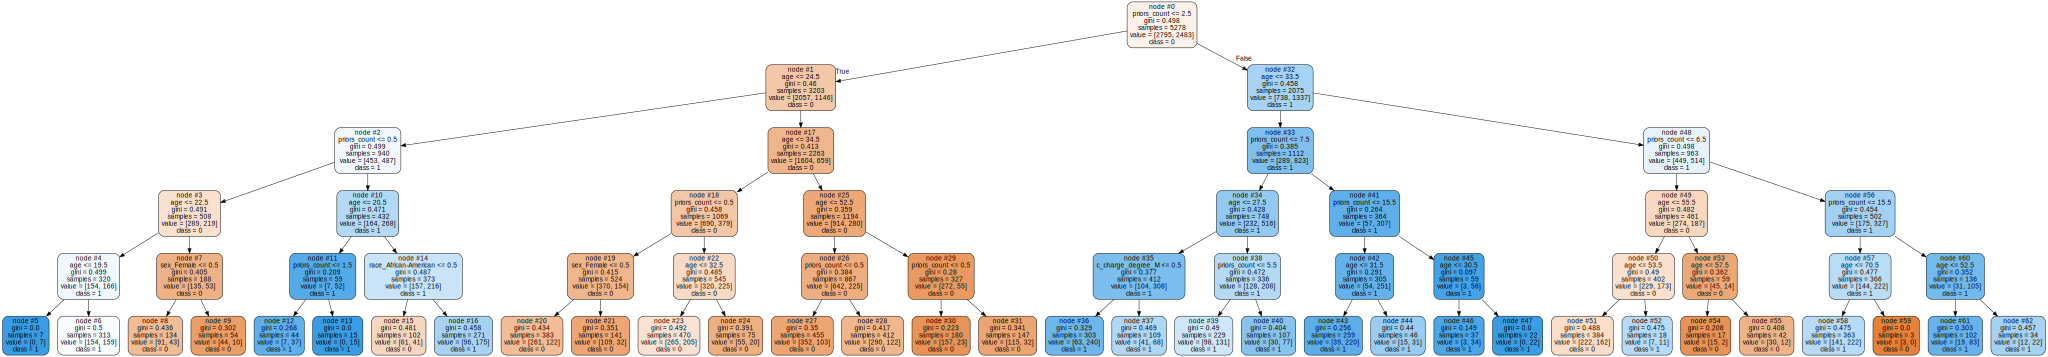

In [15]:
#@title Train and Visualize a **Decision Tree Classifier**
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#@markdown **Training**: select or type the **maximum depth** depth your tree is allowed to have (**`None`** will allow any depth):
max_depth_to_train = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

if max_depth_to_train == "None":
  max_depth_to_train = None
else:
  max_depth_to_train = np.int(max_depth_to_train)

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=max_depth_to_train, \
                                    random_state=123)
tree_model.fit(X_train, y_train)

# set up a small dictionary with the new model
all_models["tree"] = {}
all_models["tree"]["model"] = tree_model

#@markdown **Visualization**: select or type the depth you want to see (**`None`** will try printing the full tree):
max_depth_to_see = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

if max_depth_to_see == "None":
  max_depth_to_see = None
else:
  max_depth_to_see = np.int(max_depth_to_see)

dot_data = tree.export_graphviz(tree_model, max_depth=max_depth_to_see, \
                                feature_names=X_train.columns, class_names=["0","1"],
                                label='all', filled=True, impurity=True, node_ids=True, \
                                rounded=True, proportion=False)
graph = graphviz.Source(dot_data)
graph

When interpreting the tree above, note that two colors are used, **orange** and **blue**, which come in different shades. The two colors correspond to the two possible target values: **orange** corresponds to 0, and **blue** corresponds to 1, so the color used at each node basically tells you the label for the majority of the samples in that node: orange nodes have more zeros, blue nodes have more ones. The **shade** of the color tells you how dominant the label is: the more orange (respectively, blue) a node becomes, the larger the fraction of zeros (respectively, ones). You can also read this kind of information from **value**; there are two values reported there: the first corresponds to how many samples have a label 0, and the second corresponds to how many samples have a value of 1 (and the sum of these two should equal **samples**).

**Predictions** for a new sample are done by following all the conditions based on the features until a final leaf is reached. With classification problems, it is common to predict the **probability** of the target taking a value of 1, which is done by taking the **average** of the target variable for all the training samples in that leaf node. One can also obtain a prediction of the actual target **label** by taking **a majority vote** in the leaf node (which is the same as comparing the predicted probability with the threshold of 0.5).

### Model #2: A **Random Forest**


In [16]:
#@title Train a **Random Forest**
from sklearn.ensemble import RandomForestClassifier 

#@markdown Select the number of trees (estimators) to use:
n_estimators = "100" #@param [20, 50, 100, 200]
if n_estimators == "None":
  n_estimators = None
else:
  n_estimators = np.int(n_estimators)

#@markdown Select or type the depth you want to use for all the trees (selecting **`None`** will allow any depth):
max_depth_to_train = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}

if max_depth_to_train == "None":
  max_depth_to_train = None
else:
  max_depth_to_train = np.int(max_depth_to_train)

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth_to_train,
                                  criterion='gini', random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)

# add the model to the list of models
all_models["forest"] = {}
all_models["forest"]["model"] = rf_model

________
# **4. Evaluate the Predictive Accuracy**

_**Run this entire section.** Since the main point of our exercise is to discuss issues of bias and discrimination, we will only evaluate performance in the training set and will skip evaluating in the test set for simplicity (but please remember that this step is critically important in practice!)_

In [17]:
#@markdown Define some useful functions to calculate predictive performance

# #@markdown Calculate and display useful performance metrics
def calculate_metrics_classification(y_true, y_pred, y_probas_pred, \
                                     positive_label_idx=1, \
                                     label_dataset=None, display=False, \
                                     store_other=True):
        
      # Classification task
      labels = [None, None]
      labels[positive_label_idx] = 1.0
      labels[1-positive_label_idx] = 0.0
      conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=labels)

      # in SciKit learn, the rows are the true label, the columns are the predicted label   
      TP = conf_mat[positive_label_idx][positive_label_idx]
      TN = conf_mat[1-positive_label_idx][1-positive_label_idx]
      FP = conf_mat[1-positive_label_idx][positive_label_idx]
      FN = conf_mat[positive_label_idx][1-positive_label_idx]

      TPR = TP/(TP+FN) if (TP+FN>0) else "n/d"
      TNR = TN/(TN+FP) if (TN+FP>0) else "n/d"
      FPR = 1-TNR if TPR!="n/d" else "n/d"
      FNR = 1-TPR if TNR!="n/d" else "n/d"
      accuracy = metrics.accuracy_score(y_true, y_pred)
      precision = metrics.precision_score(y_true, y_pred)
      recall = metrics.recall_score(y_true, y_pred)
      sensitivity = TPR
      specificity = TNR
      roc_auc = metrics.roc_auc_score(y_true, y_probas_pred) if len(np.unique(y_true))>1 else "n/d"

      # the names of all the performance metrics
      names = ["True Positives (TP)", "True Negatives (TN)", \
              "False Positives (FP)", "False Negatives (FN)", \
              "True Positive Rate TPR=TP/(TP+FN)", \
              "True Negative Rate TNR=TN/(TN+FP)", \
              "False Positive Rate FPR=FP/(TN+FP)=1-TNR", \
              "False Negative Rate FNR=FN/(TP+FN)=1-TPR", \
              "Accuracy =(TP+TN)/(TP+FP+TN+FN)", \
              "Area Under ROC Curve (AUC)", \
              "Precision = TP/(TP+FP)", "Recall = TPR", \
              "Sensitivity = TPR", "Specificity = TNR"]

      values = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, accuracy, roc_auc, \
                precision, recall, sensitivity, specificity  ]

      # also determine roc curve and precision_recall curve
      roc_curve = metrics.roc_curve(y_true, y_probas_pred)
      prec_recall_curve = metrics.precision_recall_curve(y_true, y_probas_pred)   

      if display:
        print("Results in the {} Set:".format(label_dataset if label_dataset!=None else "Data"))
        for i in range(len(names)):
          print('{:25s} : {:.2f}'.format(names[i],values[i]))

      # compile the results into a dictionary with metrics and plots
      results = {}    
      results["metrics_names"] = names
      results["metrics_values"] = values

      if store_other:
        results["others"] = {}
        results["others"]["conf_mat"] = conf_mat
        results["others"]["roc_curve"] = roc_curve
        results["others"]["prec_recall_curve"] = prec_recall_curve
      return results

#
#
#
# #@markdown A function to predict with each ML model for all samples in a dataset
def predict_all_methods_full_dataset(all_models, X_data, y_data, \
                                     dataset="Dataset", store_df=False):

      # we will store the results in a dictionary
      results = {}      # predictions/results for each sample

      # predict with each method
      for model_name in all_models.keys():
        model = all_models[model_name]["model"] # pick the model

        y_hat = model.predict(X_data)  # predict for entire training set
        pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
        y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

        # calculate summary performance
        summary = calculate_metrics_classification(y_data, y_hat, y_prob, \
                                                  pos_label_idx, \
                                                  label_dataset=dataset, display=False, \
                                                  store_other=False)

        # a dictionary with the results
        aux = {}
        aux["y_hat"] = y_hat
        aux["pos_label_idx"] = pos_label_idx
        aux["y_prob"] = y_prob
        aux["summary"] = summary

        # store the results in the models
        all_models[model_name][dataset] = aux

        # update the overall results dictionary
        results[model_name] = aux

        # store the dataframe with summary results as well, if desired
        if store_df :
          results[model_name]["summary_df"] = \
          pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                       index=summary["metrics_names"], columns=[model_name] )

      # now aggregate results for all samples into a single dataframe, including the predictions and errors
      results["all_samples_df"] = None

      for model_name in all_models.keys():
        results["all_samples_df"] = \
        pd.concat( [ results["all_samples_df"], \
                    pd.DataFrame({'{}_probability'.format(model_name) : \
                                  results[model_name]["y_prob"], \
                                  '{}_prediction'.format(model_name) : \
                                  results[model_name]["y_hat"]}, \
                                 index=X_train.index)],\
                  axis=1)

      # and similarly join the summary performance metrics into a single dataframe
      df_index = results[model_name]["summary"]["metrics_names"]
      df_col_names = []
      df_values = {}
      for model_name in all_models.keys():
        vals = results[model_name]["summary"]["metrics_values"]
        df_col_names += [model_name]
        df_values[model_name] = vals
      results["summary_df"] = pd.DataFrame( data = df_values, index=df_index, columns=df_col_names )

      return results    

#
#
#
# #@markdown A function to predict with a specific ML model using different thresholds for a feature
def predict_different_thresholds(model_name, model, X_data, y_data, full_data_training, \
                                 feature,  y_thresh_dict, dataset="Dataset", \
                                 save_df=True):

    # recover all the feature values from the **original** data 
    # (we do this because there may be processing for training)
    feature_values = full_data_training[feature]

    if feature_values.dtype==int or feature_values.dtype==float:
      print("Error. Predicting with different thresholds only works for categorical for now.")
      return {}

    # get the unique values of the feature
    unique_vals = feature_values.unique()

    y_hat = model.predict(X_data)  # predict for entire training set
    pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
    y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

    # figure out the values of y_predicted (potentially using different thresholds)
    if set(unique_vals).issubset(set(y_thresh_dict.keys())) :
      # all the values are proper keys
      for v in unique_vals:
        filter = (feature_values==v)
        y_hat[filter] = (y_prob[filter] >= y_thresh_dict[v])
    else:
      print("Specified keys for feature {} not sufficient".feature)
      return {}

    # we will store the results in a dictionary
    results = {}      # predictions/results for each sample

    # calculate summary performance
    summary = calculate_metrics_classification(y_true=y_data, \
                                               y_pred=y_hat, \
                                               y_probas_pred=y_prob, \
                                               positive_label_idx=pos_label_idx, \
                                               label_dataset=dataset, display=False, \
                                               store_other=False)

    # a dictionary with the results
    aux = {}
    aux["y_hat"] = y_hat
    aux["pos_label_idx"] = pos_label_idx
    aux["y_prob"] = y_prob
    aux["summary"] = summary
    aux["y_thresh_dict"] = y_thresh_dict

    # update the overall results dictionary
    results[model_name] = aux

    # store the dataframe with summary results within the model, if desired
    if save_df :
      results[model_name]["summary_df"] = \
      pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                   index=summary["metrics_names"], columns=[model_name] )

    return results

#
#
#
# #@markdown A function to visualize a binary confusion matrix
def our_plot_confusion_matrix(y_true, y_pred, class_names=None, \
                              true_on_row=True, positive_first=True, \
                              prefix_title="", figsize=(8,6), ax=None):

    # This is inspired by a similar visualization created by Google Research 
    # figure out if positive label should be first or not
    num_labels = [1, 0] if positive_first else [0, 1]
    labels = ["Positives", "Negatives"] if positive_first else ["Negatives", "Positives"]
    positive_label_idx = 0 if positive_first else 1

    strings = np.asarray([['True {}'.format(labels[0]), 'False {}'.format(labels[1])], \
                          ['False {}'.format(labels[0]), 'True {}'.format(labels[1])]])

    # get the confusion matrix
    # in SciKit, ROWS = true condition, COLUMNS = predicted condition
    conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=num_labels)

    # calculate the rates
    true_conditions = conf_mat.sum(axis=1)  # sum on a row, for the true conditions in each class
    conf_mat_rates = np.array([ [conf_mat[0,0]/true_conditions[0] if true_conditions[0] > 0 else "n/d", \
                        conf_mat[0,1]/true_conditions[0] if true_conditions[0] > 0 else "n/d"], \
                       [conf_mat[1,0]/true_conditions[1] if true_conditions[1] > 0 else "n/d", \
                        conf_mat[1,1]/true_conditions[1] if true_conditions[1] > 0 else "n/d"] 
                      ])

    # determine whether to switch the row/column based on the preference for displaying
    if true_on_row:
        # true condition on the row -- this is how it is now; just set up the x/y labels
        ylabel='Ground truth'
        xlabel='Prediction'
    else:
        # we need the true condition on the column, and the predicted on the row
        for var_ in [strings, conf_mat, conf_mat_rates]:
          var_[0,1], var_[1,0] = var_[1,0], var_[0,1]
        xlabel='Ground truth'
        ylabel='Prediction'

    # set up the names to use for each class when printing
    class_names = [ class_names[i] for i in num_labels ] if class_names!=None else\
    [str(i) for i in num_labels]

    df_cm = pd.DataFrame(
        conf_mat, index=class_names, columns=class_names, 
    )

    #sns.set_context("notebook", font_scale=1.25)
    ax = ax or plt.gca()
    ax.set_title(prefix_title + 'Confusion Matrix ')

    # Combine the numerical value with its description
    labels = (np.asarray(
        ["{0:g}\n{1}\n(Rate: {2:.2f}%)".format(value, string, rate*100) \
         for value, string, rate in zip(
             conf_mat.flatten(), strings.flatten(), conf_mat_rates.flatten())\
         ])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
        linewidths=2.0, cmap=sns.color_palette("Blues"), ax=ax, \
        annot_kws={"fontsize":12});
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return fig

#
#
#
# #@markdown Function to evaluate predictive performance depending on a feature 
def evaluate_performance_with_feature_values(model_name, model, feature, X_data, \
                                             y_data, full_data_training, \
                                             results_full_data,\
                                             num_bins=3, \
                                             prefix_title="", class_names=None,\
                                             display_conf_mat=True,\
                                             display_roc_pr=True, plot_together=False,\
                                             ax_roc=None, ax_pr=None, figsize=(7,7)):

  # select the right model to use and the right column to use for summary results
  y_hat = results_full_data["y_hat"]
  y_prob = results_full_data["y_prob"]
  pos_index = results_full_data["pos_label_idx"]

  # recover all the feature values from the **original** data 
  # (we do this because there may be processing for training)
  feature_values = full_data_training[feature]

  if feature_values.dtype==int or feature_values.dtype==float:
    # if numeric feature - handle separately by discretizing
    print("{} is a numeric feature. Will discretize into {} bins.".format(feature,num_bins))
    feature_values, bins =  pd.cut(feature_values, bins=num_bins, retbins=True,\
                                   include_lowest=True, ordered=True)

  # get the unique values of the feature
  unique_vals = feature_values.unique()

  # get the summary performance for the model in the full data 
  results = results_full_data["summary_df"].copy()
  results.rename(columns={model_name:"Entire Dataset"})
      
  # a few plotting settings
  fontsize = 12  # font size for titles in plots

  if display_conf_mat :
    # display the confusion matrices
    num_figs = 1+len(unique_vals)   # calculate how many

    fig_cm = plt.figure(figsize=(figsize[0]*num_figs,figsize[1]))  # create a figure of the desired size
    
    # get all the axes for subplots
    axs_cm = fig_cm.subplots(1, num_figs)

    # plot the confusion matrix for entire data
    aux = our_plot_confusion_matrix(y_true=y_data, y_pred=y_hat,\
                                    class_names=class_names, \
                                    true_on_row=True, positive_first=True, \
                                    prefix_title="", \
                                    figsize=(fig_width,fig_heigth), ax=axs_cm[0])
    axs_cm[0].set_title(prefix_title + "Confusion Matrix with Entire Dataset",\
                        fontsize=fontsize)


  if display_roc_pr:
    # if we want to display the ROC / prec-recall curves

    # cmap = mpl.cm.get_cmap("Blues")
    cmap = mpl.cm.get_cmap("jet")

    if (plot_together==False) or (ax_roc==None) or (ax_pr==None):
        # cannot plot together
        plot_together = False
        roc_pr_fig = plt.figure(figsize=(figsize[0]*2,figsize[1]))  # create a figure of the desired size
        
        ax_roc, ax_pr = roc_pr_fig.subplots(1,2)

        # settings for the ROC curve
        # set the colors into different shades of blue
        ax_roc.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])
    
        # settings for the precision-recall curve
        # set the colors into different shades of blue
        ax_pr.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])

        # will not use any prefix for the labels in the legend
        label_prefix = ""
        linestyle = "-"
    else:
        # we will be plotting the ROC/prec-recall on top of existing plots
        label_prefix = prefix_title   # use prefix in the legend
        prefix_title = ""     # no prefix in the title
        linestyle = "--"
    
    metrics.plot_roc_curve(model, X_data, y_data, \
                           sample_weight=None, response_method='auto', \
                           name='{}Entire data'.format(label_prefix), ax=ax_roc,\
                           linestyle=linestyle)
    ax_roc.set_title("{}Comparison of ROC Curves for '{}'".format(prefix_title,feature),\
                     fontsize=fontsize)

    # plot precision-recall curve with full dataset
    metrics.plot_precision_recall_curve(model, X_data, y_data, \
                                        sample_weight=None, response_method='auto', \
                                        name='{}Entire data'.format(label_prefix), ax=ax_pr, \
                                        linestyle=linestyle)
    ax_pr.set_title("{}Comparison of Precision-Recall Curves for '{}'".\
                    format(prefix_title,feature),fontsize=fontsize)
  else:
    ax_roc = None
    ax_pr = None

  # go through each individual value for the feature and calculate metrics + do plots
  for i in range(len(unique_vals)):
    v = unique_vals[i]
    filter = (feature_values==v)  # filter for all samples with value v
    if (len(y_data[filter])):
      results_v = calculate_metrics_classification(y_true=y_data[filter], \
                                                   y_pred=y_hat[filter], \
                                                   y_probas_pred=y_prob[filter], \
                                                   positive_label_idx=pos_index, \
                                                   display=False)
            
      # copy the column with aggregate results on the entire dataset
      col_v_name = "{}={}".format(feature,v)
      aux = pd.DataFrame( data=results_v["metrics_values"], \
                         index=results_full_data["summary_df"].index, columns=[col_v_name]  )
      results = results.merge(right=aux, left_index=True, right_index=True)

      # if needed, visualize the confusion matrix
      if display_conf_mat:
          # plot the confusion matrix with the correct feature
          aux = our_plot_confusion_matrix(y_true=y_data[filter], \
                                          y_pred=y_hat[filter],\
                                          class_names=class_names, \
                                          true_on_row=True, positive_first=True, \
                                          prefix_title="", \
                                          figsize=(fig_width,fig_heigth), ax=axs_cm[1+i])
          axs_cm[1+i].set_title(prefix_title + col_v_name,fontsize=fontsize)

      if display_roc_pr:
        # plot ROC curve with partial data
        label = "{}{}".format(label_prefix,col_v_name)
        metrics.plot_roc_curve(model, X_data[filter], y_data[filter], \
                              sample_weight=None, response_method='auto', \
                              name=label, ax=ax_roc,  linestyle=linestyle)

        # plot precision-recall curve with partial data
        metrics.plot_precision_recall_curve(model, X_data[filter], y_data[filter], \
                                            sample_weight=None, response_method='auto', \
                                            name=label, ax=ax_pr, linestyle=linestyle)
    else:
      print('Feature {} has no values equal to {}. Will omit that category.'.format(feature,v))

  return results, ax_roc, ax_pr

In [18]:
#@title **Let's predict in the entire <font color=red>training data</font> and display a few samples**
all_results = predict_all_methods_full_dataset(all_models, X_train, y_train, \
                                              dataset="train", store_df=True)

# join the results for all samples into a single dataframe, including the training data, predictions and errors
all_results["all_samples_and_data_df"] = pd.concat( [ train_copy[included_features_with_target].copy(), \
                                                 all_results["all_samples_df"] ], axis=1)

#@markdown <br>Display a few samples to compare the methods: select or type how many samples to display:
num_samp = "9" #@param [5, 10, 20] {allow-input:true}

#@markdown <br>Interpretation of what you are seeing:
#@markdown - **probability** : the predicted probability that the target is 1
#@markdown - **prediction** : the predicted target, based on thresholding the probability at level 0.5
all_results["all_samples_and_data_df"].head(np.int(num_samp))

,age,c_charge_degree,race,sex,priors_count,two_year_recid,tree_probability,tree_prediction,forest_probability,forest_prediction
id,,,,,,,,,,
3,34,F,African-American,Male,0,1,0.32,0,0.39,0
4,24,F,African-American,Male,4,1,0.79,1,0.73,1
8,41,F,Caucasian,Male,14,1,0.61,1,0.64,1
10,39,M,Caucasian,Female,0,0,0.23,0,0.19,0
14,27,F,Caucasian,Male,0,0,0.32,0,0.37,0
15,23,M,African-American,Male,3,1,0.62,1,0.64,1
16,37,M,Caucasian,Female,0,0,0.23,0,0.19,0
18,41,F,African-American,Male,0,0,0.23,0,0.34,0
19,47,F,Caucasian,Female,1,1,0.30,0,0.31,0


### How to Summarize Performance for a Binary Classifier?
*If you are not that familiar with classification tasks or hypothesis testing, you may want to briefly expand this section for a description of the **many ways** used to quantify theirperformance, and a brief discussion of the (potentially confusing) **terminology**.*

The next step is to determine the aggregate performance of our ML model in the entire training data. Since **binary classification tasks** like the one here appear in many different application domains (e.g., healthcare, military, engineering, etc.), different fields have come up with slightly different performance metrics and even different terminology for the same metric, so things can get quite confusing. In a nutshell, we can evaluate performance either by looking at the **predicted labels** or by looking at the **predicted probabilities**. To make sure everyone is on the same page, we will try to include a brief description below for both, which should be more than sufficient for our purposes here. 

<br><font color=black>**Evaluating performance based on predicted labels.**</font><br>
Since there are two possible values for the ground truth ($y=0$ or $y=1$) and our ML model can predict two possible labels ($\hat{y}=0$ or $\hat{y}=1$), four cases can arise. To refer to these four cases quickly, statisticians have come up with a simple "encoding": 
> - use **true** for cases where the prediction matches the ground truth, and **false** for cases where the prediction is wrong;
> - use **positive** for cases where the predicted label is $\hat{y}=1$, and **negative** for cases where the predicted label is $\hat{y}=0$.

This gives rise to the following four cases and associated terminology:

> * <font color=green>**True Positive (TP)**</font>: the model predicts a positive label ($\hat{y}=1$), and that matches the ground truth ($y=1$).
> * <font color=green>**True Negative (TN)**</font>: the model predicts a negative label ($\hat{y}=0$), and that matches the ground truth ($y=0$).
> * <font color=red>**False Positive (FP)**</font>: the model predicts a positive label ($\hat{y}=1$), but in reality the label is negative ($y=0$).
> * <font color=red>**False Negative (FN)**</font>: the model predicts a negative label ($\hat{y}=0$), but in reality the label is positive ($y=1$).

It is common to list these four values in a (hopefully not too confusing!) 2x2 matrix called a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix), which is a very concise way to summarize the performance of a binary classifier. Additionally, these can be used as a starting point to calculate various other performance metrics, as follows:
- **True Positive Rate (TPR)**: the fraction of positive labels correctly identified as positive **TP/(TP+FN)**
- **True Negative Rate (TNR)**: the fraction of negative labels correctly identified as negative, **TN/(TN+FP)** 
- **False Positive Rate (FPR)**: the fraction of negative labels incorrectly identified as positive, **FP/(FP+TN) = 1 - TNR**
- **False Negative Rate (FNR)**: the fraction of positive labels incorrectly identified as negative, **FN/(FN+TP) = 1 - TPR**
- **Accuracy**: the fraction of labels correctly identified, **(TP+TN)/(TP+TN+FP+TN)**
- [**Sensitivity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity): another term for **TPR**
- [**Specificity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity): another term for **TNR**
- [**Precision**](https://en.wikipedia.org/wiki/Precision_and_recall): the fraction of labels identified as positive that are actually positive, **TP/(TP+FP)**.
- [**Recall**](https://en.wikipedia.org/wiki/Precision_and_recall): yet another term for **TPR**.

In addition to these, there are several terms used for the same metrics, and also others metrics that can be computed (see some of the links above for examples).

> **Quick historical note.** *Positive* and *negative* should not be interpreted in any way as value judgments! They are standard terms that came about because of the historical context and the motivating applications: predictions were often made as part of some kind of **test** (for instance, to check if a disease is present or whether an enemy submarine is nearby), and  a **positive  outcome in the test** amounted to conditions that were statistically surprising and needed follow-up action.

<br>**Evaluating performance based on predicted probabilities.**<br>
The predicted labels are actually defined by thresholding the predicted probabilities at a value of 0.5. However, it is natural to ask how the predictions and errors would change if this threshold took a different value, as this would present a much better picture of the overall performance of the binary classifier, without overly relying on the (potentially ad-hoc) thresholding at 0.5. This is commonly done by varying the threshold from 0 to 1 and plotting two of the metrics above as a function of the threshold.  This gives rise to two well known plots:

- A [receiver operating characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve is created by plotting the true positive rate (**TPR**) against the false positive rate (**FPR**) at various threshold settings. The curves in these kinds of plots always start at (0,0), end at (1,1), and are monotonically increasing. If the classified is "good", we would hope to see curves that quickly go up to the value 1. Therefore, a good normalized measure of the overall performance of the classifier is given by the **area under the ROC curve (AUC)**: a perfect classifier would have a value 1, and values closer to 1 indicate better classifiers.
- A [precision-recall (PCR)](https://en.wikipedia.org/wiki/Precision_and_recall) curve plots the **precision** against the **recall**. These plots are not necessarily monotonic, but we would hope to see points that are as close to (1,1) as possible.

### Summarize Performance in Entire Training Data

The aggregate performance in the training set:


,tree,forest
True Positives (TP),"1,554.00","1,556.00"
True Negatives (TN),"2,070.00","2,115.00"
False Positives (FP),725.00,680.00
False Negatives (FN),929.00,927.00
True Positive Rate TPR=TP/(TP+FN),0.63,0.63
True Negative Rate TNR=TN/(TN+FP),0.74,0.76
False Positive Rate FPR=FP/(TN+FP)=1-TNR,0.26,0.24
False Negative Rate FNR=FN/(TP+FN)=1-TPR,0.37,0.37
Accuracy =(TP+TN)/(TP+FP+TN+FN),0.69,0.70
Area Under ROC Curve (AUC),0.74,0.75


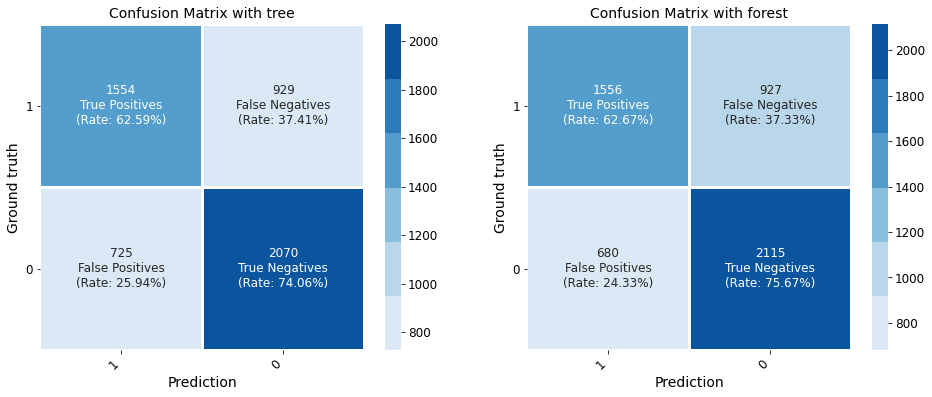

In [19]:
#@title **Let's evaluate several <font color=red>aggregate performance metrics</font> in the entire training set**

#@markdown Select which performance metrics you want to see displayed. If you are not sure what these are, expand the previous section and read the brief description.
display_all_performance_numbers = True #@param {type:"boolean"}
display_confusion_matrix = True #@param {type:"boolean"}
display_ROC_and_precision_recall_curves = False #@param {type:"boolean"}

if display_all_performance_numbers:
    print("The aggregate performance in the training set:")
    display(all_results["summary_df"])

#@markdown <br>**You can further customize some aspects of the plot**
#@markdown - **`fig_width`** : the width of each figure in inches (leave as **Auto** if unsure)
#@markdown - **`fig_height`** : the height of each figure in inches (leave as **Auto** if unsure)

fig_width = 'Auto' #@param ['Auto']{allow-input : true}
fig_height = 'Auto' #@param ['Auto']{allow-input : true}
if fig_width=='Auto':
  fig_width=8.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=6.0
else:
  fig_height=np.float(fig_height)

all_model_names = list(all_models.keys())
num_models = len(all_model_names)

# confusion matrix
if display_confusion_matrix:
    # separate plots for each method
    fig_width = 8.0
    fig_heigth = 6.0
    fig = plt.figure(figsize=(fig_width*num_models,fig_heigth))  # create a figure of the desired size
    for i in range(num_models):
      model_name = all_model_names[i]
      plt.subplot(1,num_models,1+i)
      ax=plt.gca()
      aux = our_plot_confusion_matrix(y_true=y_train, y_pred=all_results[model_name]["y_hat"],\
                                      class_names=None, \
                                      true_on_row=True, positive_first=True, \
                                      prefix_title="", \
                                      figsize=(fig_width,fig_heigth), ax=ax)
      ax.set_title("Confusion Matrix with {}".format(model_name),fontsize=14)

# ROC and precision-recall 
if display_ROC_and_precision_recall_curves :

    # create a single figure: left for ROC, right for PRC (if both plots needed)
    roc_pr_fig = plt.figure(figsize=(fig_width*2,fig_height))  # create a figure of the desired size
    ax_roc, ax_pr = roc_pr_fig.subplots(1,2)

    # set the colors based on jet map
    cmap = mpl.cm.get_cmap("jet")
    ax_roc.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, num_models)])
    ax_pr.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, num_models)])

    ax_roc.set_title("ROC Curves with Each Model",fontsize=14)
    for i in range(num_models):
      model_name = all_model_names[i]
      metrics.plot_roc_curve(all_models[model_name]["model"], X_train, y_train, \
                            sample_weight=None, response_method='auto', \
                            name=model_name, ax=ax_roc)

    ax_pr.set_title("Precision-Recall Curves with Each Model",fontsize=14)
    for i in range(num_models):
      model_name = all_model_names[i]
      metrics.plot_precision_recall_curve(all_models[model_name]["model"], X_train, y_train, \
                                          sample_weight=None, response_method='auto', \
                                          name=all_model_names[i], ax=ax_pr)

    #plt.tight_layout()
    plt.show()

# **5. Evaluating Bias**
The next step is the main task that we are interested in this exercise, namely to understand whether the model is exhibiting any bias/unfairness. Specific issues to be on the lookout for are:
 - **Are the model's predictions correlated with any of the protected features?**<br>_(This can be investigated by examining how predictions depend on features, e.g., through **partial dependence plots**.)_
 - **Is the model delivering substantially different performance for different categories, and particularly for protected characteristics?**
 <br>_(This can be investigated by examining how predictive accuracy depends on the categories.)_

### Does the Predictive Performance Change with Feature Values?

Your selection:
Model:        forest
Feature(s):   sex

Displaying detailed performance metrics:


,forest,sex=Male,sex=Female
True Positives (TP),"1,556.00","1,385.00",171.00
True Negatives (TN),"2,115.00","1,530.00",585.00
False Positives (FP),680.00,607.00,73.00
False Negatives (FN),927.00,725.00,202.00
True Positive Rate TPR=TP/(TP+FN),0.63,0.66,0.46
True Negative Rate TNR=TN/(TN+FP),0.76,0.72,0.89
False Positive Rate FPR=FP/(TN+FP)=1-TNR,0.24,0.28,0.11
False Negative Rate FNR=FN/(TP+FN)=1-TPR,0.37,0.34,0.54
Accuracy =(TP+TN)/(TP+FP+TN+FN),0.70,0.69,0.73
Area Under ROC Curve (AUC),0.75,0.74,0.76


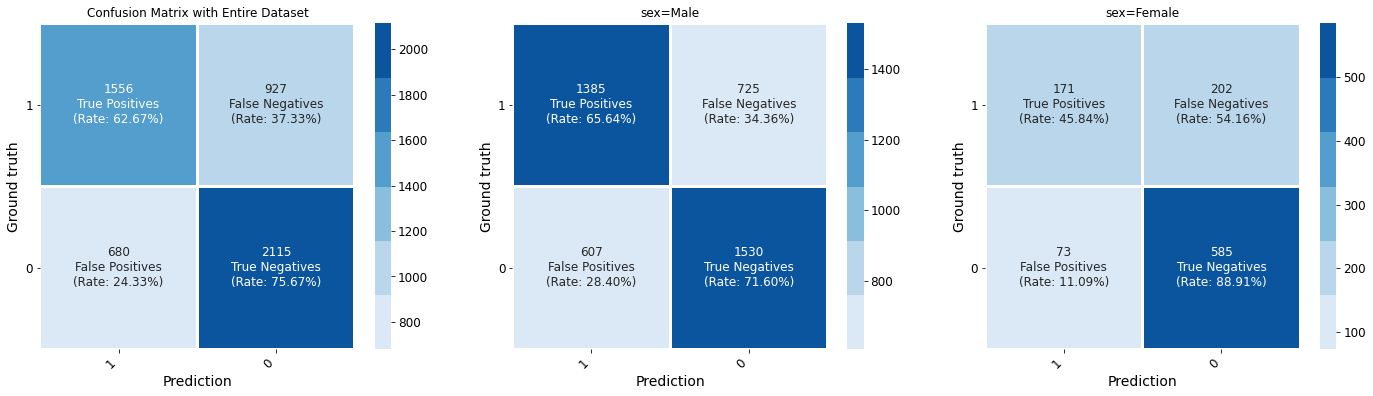

In [20]:
#@title **Determine whether predictive performance depends on the features**

#@markdown Select **one of the models** we trained:
model_name = "forest" #@param ["tree", "forest"]

#@markdown Select a **feature** to examine:
feature = "sex" #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count']

#@markdown (Numerical features will be discretized into bins. You can select how many bins to use below:)
num_bins = "3" #@param [2,3,4,5]{allow-input:true}
num_bins = np.int(num_bins)

print("Your selection:")
print("Model:        {}".format(model_name))
print("Feature(s):   {}".format(feature))

#@markdown <br>**Feel free to customize what information is displayed:**
display_all_performance_numbers = True #@param {type:"boolean"}
display_confusion_matrix = True #@param {type:"boolean"}
display_ROC_and_precision_recall_curves = False #@param {type:"boolean"}

# if the dictionary to store results by feature for that model does not exist, create it
if "by_feature" not in all_results[model_name].keys():
  all_results[model_name]["by_feature"] = {} 

all_results[model_name]["by_feature"][feature], ax_roc, ax_pr = \
evaluate_performance_with_feature_values(model_name=model_name, \
                                         model=all_models[model_name]["model"],\
                                         feature=feature, X_data=X_train, \
                                         y_data=y_train, 
                                         full_data_training=train_set, \
                                         results_full_data=all_results[model_name],\
                                         num_bins=num_bins, \
                                         prefix_title="", class_names=None,\
                                         display_conf_mat=display_confusion_matrix,\
                                         display_roc_pr=display_ROC_and_precision_recall_curves, \
                                         plot_together=False,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(8,6))

if display_all_performance_numbers:
    print("\nDisplaying detailed performance metrics:")
    display(all_results[model_name]["by_feature"][feature])

### Are the Model's Predictions Correlated with Specific Features?

_**Run the entire sub-section** and expand for an explanation and the visualizations._


The best way to examine this, which also works for black-box models, is by using **partial dependence plots**. To understand what these plots are all about, suppose you want to know how the predictions of a complex ML model depend on some feature $X$. One thing you could do is to consider different values $x$ for the feature of interest, and for every such value, calculate the prediction in all the samples in your dataset when you force the value of $X$ in each sample to take the value $x$. You could then take the average of all the predictions, and plot this as a function of $x$. This dependency is exactly what is shown in a **partial dependence plot**. 

In [21]:
#@markdown Define a function to do **partial dependence plots** as a function of one or two features
def visualize_partial_dependency(model, all_data_with_dummies, all_categories, \
                                 model_features, feature_x1, feature_x2=None,\
                                 target_name="target", num_bins=10, \
                                 uniform_bins=False, figsize=(10,9)):
   
    # append to all categories a string for numeric categories
    all_feats = [feature_x1]
    if feature_x2 != None:
      all_feats += [feature_x2]

    categ_for_infoplot = all_categories.copy()
    for feat_ in all_feats:
      if feat_ not in all_categories.keys():
        # just the names for numeric features
        categ_for_infoplot[feat_] = feat_

    if uniform_bins:
      grid_type='equal'
    else:
      grid_type='percentile'
    
    # do all the PDPs
    if feature_x2==None:
      # visualizing just two features, so a simple target_plot will do
      title = "Relation between the predicted '{}' and feature '{}'".\
      format(target_name,feature_x1)
      subtitle = "The solid center line shows the average, and several individual samples are also shown in thin blue lines."

      pdp_feat = pdp.pdp_isolate(model=model,\
                                 dataset=all_data_with_dummies,\
                                 model_features=model_features,\
                                 feature=categ_for_infoplot[feature_x1],\
                                 num_grid_points=num_bins, grid_type=grid_type, \
                                 percentile_range=None, grid_range=None, \
                                 cust_grid_points=None)
      fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat, feature_name=feature_x1,\
                               center=False,
                               plot_lines=True,
                               frac_to_plot=100,
                               plot_pts_dist=True,\
                               figsize=figsize,\
                               plot_params = {'title': title,\
                                              'subtitle': subtitle,\
                                              'title_fontsize': 15,
                                              'subtitle_fontsize': 12,
                                              'font_family': 'Arial'})

    else:
      # plotting y as color-coded, as a function of x1 and x2
      title = "Relation between predicted '{}' and features '{}' and '{}'".\
      format(target_name,feature_x1,feature_x2)
      subtitle = "The circle color shows the average value of the predicted target" +\
        "\n and the circle size shows the number of samples."

      pdp_feat = pdp.pdp_interact(model=model, dataset=all_data_with_dummies,\
                                  model_features=model_features,\
                                  features=[categ_for_infoplot[feature_x1],\
                                            categ_for_infoplot[feature_x2]],\
                                  num_grid_points=[num_bins,num_bins], \
                                  grid_types=[grid_type,grid_type],\
                                  percentile_ranges=None, grid_ranges=None)

      fig, axes = \
      pdp.pdp_interact_plot(pdp_interact_out=pdp_feat, \
                            feature_names=[feature_x1,feature_x2],\
                            plot_type='grid', x_quantile=False, \
                            plot_pdp=False, which_classes=None, \
                            figsize=figsize, ncols=2, \
                            plot_params = {'title': title,\
                                           'subtitle': subtitle,\
                                           'title_fontsize': 15,
                                           'subtitle_fontsize': 12,
                                           'font_family': 'Arial'})

Your selections:
Model :                 forest
Feature_1 :             race
Feature_2 :             None


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


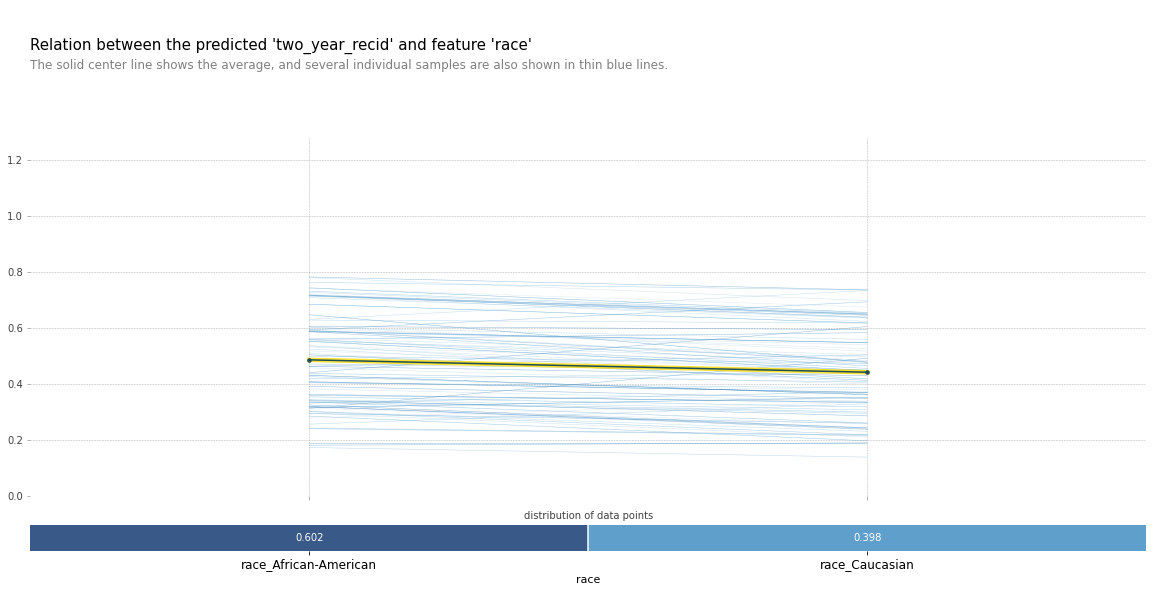

In [22]:
#@title Partial Dependence Plots (PDPs)

#@markdown Select **one of the models** we trained:
model_name = "forest" #@param ["tree", "forest"]

# append dummies and store categories for all data (useful for plotting routines)
X_data_with_dummies, X_data_categories = append_dummies(train_copy, train_copy.columns)

#@markdown Select one feature to examine partial dependency of the predictions:
feature_1 = 'race' #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count']

#@markdown (Optional) An additional numeric or categorical feature to visualize:
feature_2 = "None" #@param ['None', 'age', 'c_charge_degree', 'race', 'sex', 'priors_count']

#@markdown <br>**You can further customize some aspects of the plot**

#@markdown General settings:
fig_width = '20' #@param ['Auto']{allow-input : true}
fig_height = '10' #@param ['Auto']{allow-input : true}

#@markdown For an average dependency plot:
#@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
#@markdown - **`equal_probability`** : whether to use bins with roughly equal probability (unchecking this will generate bins with equal width)
num_bins = '10' #@param ['Auto']{allow-input : true}
equal_probability = True #@param {type:"boolean"}

# print the selections
print("Your selections:")
print("Model :                ", model_name)
print("Feature_1 :            ", feature_1)
print("Feature_2 :            ", feature_2)

# set up parameters properly
if feature_2=="None":
  feature_2 = None

if fig_width=='Auto':
  fig_width=7.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=7.0
else:
  fig_height=np.float(fig_height)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

visualize_partial_dependency(model = all_models[model_name]["model"], \
                             all_data_with_dummies=X_data_with_dummies,\
                             all_categories=X_data_categories, \
                             model_features=X_train.columns,\
                             feature_x1=feature_1,feature_x2=feature_2,\
                             num_bins=num_bins,\
                             target_name='two_year_recid',\
                             uniform_bins=(not equal_probability),\
                             figsize=(fig_width,fig_height))


Partial dependence plots (PDPs) are powerful tools to help you understand the inner workings on your trained Machine Learning model. To use them responsibly, it is worth knowing both the advantages and disadvantages.

<font color=black>**Advantages:** </font>
1. PDPs are an **intuitive** way to measure dependency: the average prediction if we forced all data points to assume a specific feature value
2. PDPs are **easy to implement**: all that is required is to predict using our model, compute averages and plot
3. PDPs yield a **causal interpretation for the model**: we are examining how changes in just one feature impact the prediction, so this is a causal dependency within the context of the model. (<font color=red>CAUTION: there is **no** causal statement here about real life!</font>)  
4. PDPs are an **acccurate assesssment of dependency** if the plotted features are independent of all other features: in this case, the PDP perfectly interprets how the plotted features influences the prediction on average.

<font color=black>**Disadvantages:** </font>
1. You can visualize **at most two features** at once.  
2. PDPs **assume independence**. We already mentioned this briefly above, but the calculations done with a PDP are guaranteed to be an accurate estimate of impact only when the plotted feature(s) are uncorrelated of other features. (Some other methods are more effective for correlated features, e.g., [Accumulated Local Effect plots](https://christophm.github.io/interpretable-ml-book/ale.html#ale).)  
3. PDPs only capture averages, and thus might **hide heterogeneous effects**. (A potential fix are [Individual Conditional Expectation curves](https://christophm.github.io/interpretable-ml-book/ice.html#ice)).

Some other tools are available to understand dependencies and to quantify the impact of features in **black-box** models. For more details and pointers, please refer to our final section on things left out.

# **6. Potential Fixes to Reduce Bias**

## Change the Features Included in Training

One of the first things to try is to change the features/data included when training the ML algorithm. For instance, we could try to eliminate the protected features from the training set.

In [23]:
#@title **Select a new model and the features to use in training**

#@markdown Pick a model and the **maximum depth** depth for trees:
new_model_name = "forest" #@param ["tree", "forest"]
max_depth_to_train = "5" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] {allow-input: true}
max_depth_to_train = np.int(max_depth_to_train)

#@markdown Pick **which features** to include in the training by ticking the box:
age = True #@param {type:"boolean"}
#age_cat = True #@param {type:"boolean"}
c_charge_degree = True #@param {type:"boolean"}
race = False #@param {type:"boolean"}
sex = True #@param {type:"boolean"}
priors_count = True #@param {type:"boolean"}

# mapping between the variables and the names
var_names = ["age", "c_charge_degree", "race", "sex", "priors_count"]
#var_names = ["age_cat", "c_charge_degree", "race", "sex", "priors_count"]
selection = [age, c_charge_degree, race, sex, priors_count]

new_X_train = None

if new_model_name=="tree":
  new_model = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth_to_train, \
                                    random_state=123)
elif new_model_name=="forest":
  new_model = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth_to_train,
                                  criterion='gini', random_state=42, oob_score=True)

print("Your selection of model and variables to include:")
print("Model:        {}".format(new_model_name))
print("Variables:")

for i in range(len(var_names)):

  if selection[i] == True:
    col = var_names[i]
    if (train_set[col].dtype==int or train_set[col].dtype==float):
      # numeric variable
      new_X_train = pd.concat( [new_X_train, train_set[col]], axis=1 )
      print("{:20s} : including as is (numeric)".format(col))
    else:
      # categorical variable
      new_X_train = pd.concat( [new_X_train, pd.get_dummies(train_set[col], prefix=col)], axis=1 )
      print("{:20s} : turning into dummies".format(col))
      #print("{:20s} : turning into dummies and removing last level '{}'".format(col,new_X_train.columns[-1]))
      #new_X_train.drop(columns=new_X_train.columns[-1], inplace=True)

# the target variables
new_y_train = train_set["two_year_recid"]

# train and evaluate the model
#new_models, new_results = train_and_evaluate(new_model, new_model_name, new_X_train, new_y_train)

# train the model
new_model.fit(new_X_train, new_y_train)

# set up a dictionary with the new model
new_models = {}
new_models[new_model_name] = {}
new_models[new_model_name]["model"] = new_model

# predict with the new model in the entire training data
new_results = predict_all_methods_full_dataset(new_models, new_X_train, new_y_train, \
                                              dataset="train", store_df=True)

Your selection of model and variables to include:
Model:        forest
Variables:
age                  : including as is (numeric)
c_charge_degree      : turning into dummies
sex                  : turning into dummies
priors_count         : including as is (numeric)


Your selection:
Feature(s):          race
Compare with old:    True


,forest_NEW,race=African-American_NEW,race=Caucasian_NEW,forest_OLD,race=African-American_OLD,race=Caucasian_OLD
True Positives (TP),"1,565.00","1,177.00",388.00,"1,556.00","1,249.00",307.00
True Negatives (TN),"2,099.00","1,029.00","1,070.00","2,115.00",959.00,"1,156.00"
False Positives (FP),696.00,485.00,211.00,680.00,555.00,125.00
False Negatives (FN),918.00,484.00,434.00,927.00,412.00,515.00
True Positive Rate TPR=TP/(TP+FN),0.63,0.71,0.47,0.63,0.75,0.37
True Negative Rate TNR=TN/(TN+FP),0.75,0.68,0.84,0.76,0.63,0.90
False Positive Rate FPR=FP/(TN+FP)=1-TNR,0.25,0.32,0.16,0.24,0.37,0.10
False Negative Rate FNR=FN/(TP+FN)=1-TPR,0.37,0.29,0.53,0.37,0.25,0.63
Accuracy =(TP+TN)/(TP+FP+TN+FN),0.69,0.69,0.69,0.70,0.70,0.70
Area Under ROC Curve (AUC),0.75,0.75,0.72,0.75,0.75,0.73


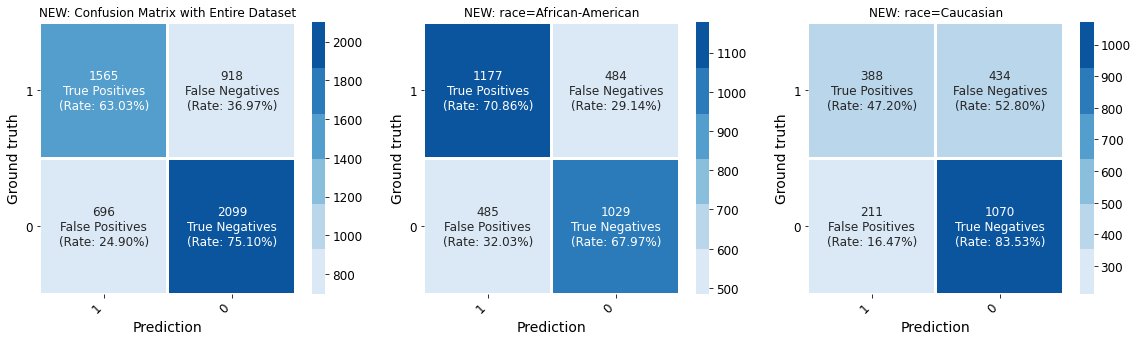

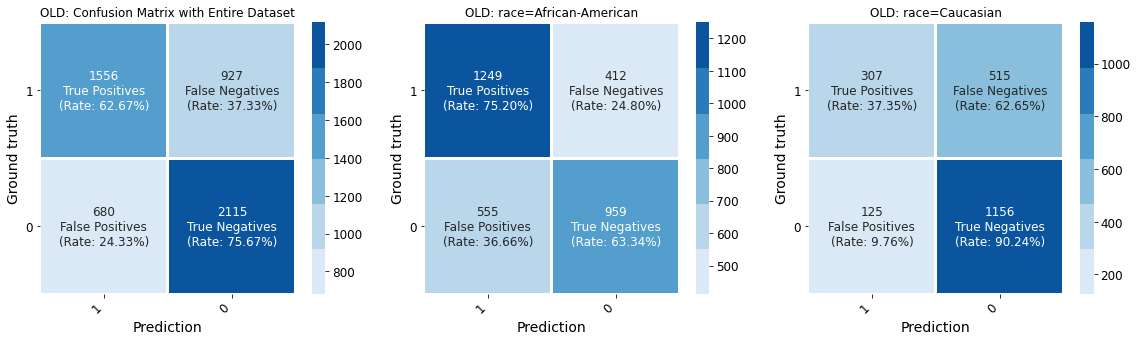

In [24]:
#@title **Examine the bias in the new model**

#@markdown For the **new model**, select a specific **feature** to examine for bias. (Numerical features will be discretized; select how many bins to use below:)
feature = "race" #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count']
num_bins = "3" #@param [2,3,4,5]{allow-input:true}
num_bins = np.int(num_bins)

#@markdown <br>Customize what information is displayed:
display_all_performance_numbers = True #@param {type:"boolean"}
display_confusion_matrix = True #@param {type:"boolean"}
display_precision_recall = False #@param {type:"boolean"}

#@markdown <br>Compare the **new model** with the **old model** for the specific feature? (Picking **"No"** will display performance for the new model only)
compare = True #@param {type:"boolean"}

#@markdown <br>Customize your plot:<br>
figure_width = "6.5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_width=="Auto":
  figure_width=7.0
else:
  figure_width=np.float(figure_width)

figure_height = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_height=="Auto":
  figure_height=7.0
else:
  figure_height=np.float(figure_height)

print("Your selection:")
print("Feature(s):          {}".format(feature))
print("Compare with old:    {}".format(compare))

if ("by_feature" not in new_results[new_model_name].keys() ):
  new_results[new_model_name]["by_feature"] = {} # reset the dictionary for results by feature

new_results[new_model_name]["by_feature"][feature], ax_roc, ax_pr = \
evaluate_performance_with_feature_values(model_name=new_model_name, \
                                        model=new_models[new_model_name]["model"], \
                                        feature=feature, X_data=new_X_train, \
                                        y_data=new_y_train, \
                                        full_data_training=train_set, \
                                        results_full_data=new_results[new_model_name],\
                                        num_bins=num_bins, \
                                        prefix_title="NEW: ", \
                                        class_names=None,\
                                        display_conf_mat=display_confusion_matrix,\
                                        display_roc_pr=display_precision_recall, \
                                        plot_together=compare, \
                                        figsize=(figure_width,figure_height))

if compare:
    # check to see if we have results from the "old" model for the same feature
    if ("by_feature" not in all_results[new_model_name].keys() ):
      all_results[new_model_name]["by_feature"] = {}

    all_results[new_model_name]["by_feature"][feature], ax_roc, ax_pr = \
    evaluate_performance_with_feature_values(model_name=new_model_name, \
                                        model=all_models[new_model_name]["model"], \
                                        feature=feature, X_data=X_train, \
                                        y_data=y_train, \
                                        full_data_training=train_set, \
                                        results_full_data=all_results[model_name],\
                                        num_bins=num_bins, \
                                        prefix_title="OLD: ", \
                                        class_names=None,\
                                        display_conf_mat=display_confusion_matrix,\
                                        display_roc_pr=display_precision_recall, \
                                        plot_together=compare, \
                                        figsize=(figure_width,figure_height))

    results_to_display = pd.merge( left=new_results[new_model_name]["by_feature"][feature], \
                                  right=all_results[new_model_name]["by_feature"][feature], \
                                  left_index=True, right_index=True,\
                                  how="inner", suffixes=("_NEW", "_OLD") )

else:
    results_to_display = new_results[new_model_name]["by_feature"][feature]

if display_all_performance_numbers:
    display(results_to_display)

## **Other Options**

### Additional Tools for Controlling for Bias/Discrimination

Tech companies have developed packages and tools that allow to explicitly check for bias/fairness, and improve algorithms at various stages of the ML pipeline: at the data pre-processing stage, internally or at post-processing. For more details, see:

- [IBM's AI Fairness 360](https://github.com/Trusted-AI/AIF360) : a repository of tools (R and Python)
- [Microsoft's FATE](https://www.microsoft.com/en-us/research/theme/fate/) (Fairness, Accountability, Transparency, and Ethics in AI) : a website with many resources
- [Google PAIR](https://research.google/teams/brain/pair/) has developed a powerful open-source tool called [What-If](https://pair-code.github.io/what-if-tool/get-started/) that allows inspecting classification or regression models to detect discrimination or bias.


# **7. References**
If you would like to learn more about some of the topics covered here, the following are a great set of resources:
 1. [An Introduction to Statistical Learning with Applications in R](https://www.springer.com/gp/book/9781461471370) by Gareth James, Daniela Witten, Trevor Hastie and Rob Tibshirani. Excellent and very accesible reference for conceptual elements + implementation in R.
 2. [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) by Aurélien Géron. Great reference for Machine Learning in Python, primarily on the coding and implementation side.
 3. [Interpretable ML Book: A Guide to Making Black-Box Models Interpretable](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. Great reference for going deeper on the topic of Interpretable Machine Learning.